# Assignment 3: Clustering methods for empirical research

---
## Background

### Problem Analysis
The assignment asks to employ linear regression for predictive modelling, to find the best models using different combinations of predictors and the statistical significance of the relationship between the predictors and the model outcome.  
For that purpose, we employ:
- Spearman correlation coefficient
- Principle component analysis


### What is the methods' use case?

##### Principle Component Analysis
- Identifies the most important underlying patterns or components in the data
- With that enables reduction of the dimensionality of high-dimensional data while preserving as much variance as possible
- In our case, it helps to simplify the dataset by finding a smaller number of components (or dimensions) that explain most of the variability, making it easier to identify clusters (and the contributing variables) and map aspects to those clusters

### The Methods
##### Spearman Correlation Coefficient
-> See assignment 1

##### Principal Component Analysis (PCA)
Principal Component Analysis (PCA) is a technique to simplify high-dimensional datasets by transforming them into lower dimension while keeping as much variance (which equals information content) as possible. For that purpose, it transforms the (potentially correlated) variable into less uncorrelated variables. Those uncorrelated variables are called principal components. 

Principal components are linear combinations of the original variables (e.g. of two correlated varialbe) to capture as much variance as possible per principal component while at the same time reducing the complexity (high dimensionality) of that dataset. 

PCA transforms the original data to maximize the variance along the principal components while minimizing redundancy in the information content. This is done through an orthogonal transformation, resulting in the principal components describing acting as the new axes of the cartesian coordinate system.

**Mathematical Representation:**
In PCA, we seek to find a set of principal components, $(PC_1, PC_2, \ldots, PC_n)$, such that:

$$
PC_1 = \beta_{11} X_1 + \beta_{12} X_2 + \ldots + \beta_{1p} X_p
$$
$$
PC_2 = \beta_{21} X_1 + \beta_{22} X_2 + \ldots + \beta_{2p} X_p
$$
$$
\vdots
$$
$$
PC_n = \beta_{n1} X_1 + \beta_{n2} X_2 + \ldots + \beta_{np} X_p
$$

with:
- $( X_1, X_2, \ldots, X_p)$ are the original variables.
- $( \beta_{ij} )$ denote the contribution (loading) of each original variable to the principal component $( PC_i )$.

The principal components are ordered by the amount of variance (information) of the dataset the capture, with $( PC_1 )$ capturing the most variance. Hence its is often sufficient to only consider the first few principal components that capture the most variance (information) in the dataset while losing neglectable amounts of data.

**Example:**
Let's use a small example dataset with 10 data points and 3 variables to illustrate the concept of PCA and how normality (or lack thereof) affects the principal components.

### Example Dataset

| Var 1 | Var 2 | Var 3 |
|:------:|:------:|:---:|
| 170    | 65     | 25  |
| 160    | 70     | 32  |
| 180    | 80     | 28  |
| 175    | 75     | 35  |
| 162    | 68     | 29  |
| 168    | 72     | 22  |
| 174    | 77     | 30  |
| 165    | 66     | 27  |
| 172    | 74     | 33  |
| 177    | 78     | 31  |

From the data we can alread see, that Var 1 and Var 2 seem to be correlated. If we performed a principle component analysis assuming we'd get three principal components, the componts would cover the following variance (expressed as ratio of the entire variance in the dataset):
- PC1 -> 0.6175%
- PC2 -> 0.3025%
- PC3 -> 0.08%

From this we can already deduct, that PC3 contains neglectable information content. Hence we will only focus on PC1 and PC2.

Going further in the analysis we'll get the contribution (loading) of each variable to the respective PC:

PC1 = 0.614 * Var 1 + 0.629 * Var 2 + 0.480 * Var 3
PC2 = 0.071 * Var 1 + 0.011 * Var 2 - 0.998 * Var 3

We can see, that Var 1 and Var 2 only have significant influence on PC1, while Var 3 dominates PC2, but also has an influence on PC1. As such, we can deduce, that there could be two clusters in the dataset (if we were searching for clusters) - with an overlap regarding Var 3.

**Assumptions:**
- The relationships between variables need to be linear, since PCA puts them into a linear perspective. Otherwise it won't find and reduce correlated variables into one principal component. 
- PCA works better with large samples, as small samples can lead to unstable estimates of the principal components.
- Even though PCA does not necessarily need normally distributed input data, this is helpful in the interpretation of the results (highly skewed data might result in capturing unrelated patterns)


---
## Solution

In [31]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


df = pd.read_csv('data/table_4.csv', delimiter=";")
df.drop("Subject", axis=1, inplace=True)
df.head()

,Size in LOC,Time,Prod.,Faults,Faults/ KLOC,Pred. Size,Pred.
0,839,3657,13.8,53,63.2,39.7,20.2
1,1249,3799,19.7,56,44.8,44.1,21.2
2,968,1680,34.6,71,73.3,29.1,25.1
3,996,4357,13.7,35,35.1,24.3,18.0
4,794,2011,23.7,32,40.3,26.0,13.2


We will first identify the correlations between the individual variables with the spearman correlation coefficient, as it covers what pearson covers. The downside of using spearman is a reduced accuracy regarding the strength of the correlation.

In [32]:
spearman_corr = df.corr(method='spearman')
relevant_s_corr = spearman_corr[(spearman_corr > 0.7) | (spearman_corr < -0.7)]
np.fill_diagonal(relevant_s_corr.values, np.nan)

relevant_s_corr = relevant_s_corr.where(np.tril(np.ones(relevant_s_corr.shape)).astype(bool)).fillna('')

print('Spearman Correlation')
relevant_s_corr

Spearman Correlation


,Size in LOC,Time,Prod.,Faults,Faults/ KLOC,Pred. Size,Pred.
Size in LOC,,,,,,,
Time,,,,,,,
Prod.,,-0.82995,,,,,
Faults,,,,,,,
Faults/ KLOC,,,,0.838968,,,
Pred. Size,,,,,,,
Pred.,,,,,,,


From this we can already see, that `Prod.` strongly negatively correlates with `Time`, and that `Faults/KLOC`strongly positivly correlates with `Faults`. As such, in the data we will probably have 5 instead of 7 dimensions. And we will probably see clusters that contain `Prod.` and `Time` as well as clusters with `Faults` and `Faults/KLOC`.

In [33]:
# Step 1: Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

# Step 2: Perform PCA
pca = PCA(n_components=len(df.columns))  # n_components = number of variables
pca.fit(data_scaled)

# Step 3: Get the explained variance and explained variance ratio
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame for better visualization
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance': explained_variance,
    'Explained Variance Ratio': explained_variance_ratio
})

# Display explained variance and explained variance ratio
print("Explained Variance and Explained Variance Ratio for Each Principal Component:")
display(explained_variance_df)

# Create a DataFrame for the principal component loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(df.columns))], index=df.columns)

# Display the loadings
print("PCA Loadings (Contribution of Variables to Each Component):")
display(loadings)


Explained Variance and Explained Variance Ratio for Each Principal Component:


,Principal Component,Explained Variance,Explained Variance Ratio
0,PC1,2.646236,0.371626
1,PC2,1.663667,0.233638
2,PC3,1.212686,0.170305
3,PC4,0.802796,0.112741
4,PC5,0.718895,0.100959
5,PC6,0.067664,0.009502
6,PC7,0.008745,0.001228


PCA Loadings (Contribution of Variables to Each Component):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Size in LOC,0.096726,0.644577,0.058225,-0.354593,0.507724,-0.396144,0.176986
Time,0.505370,-0.220857,-0.076316,-0.228632,0.508037,0.615919,0.016380
Prod.,-0.353422,0.608321,0.122672,0.049121,-0.165934,0.677664,0.028548
Faults,0.538613,0.309164,0.174409,0.138391,-0.215955,-0.060893,-0.717215
Faults/ KLOC,0.549040,0.142912,0.162398,0.276785,-0.350120,-0.005479,0.672707
Pred. Size,-0.135246,-0.110607,0.677955,0.546092,0.459320,-0.020429,-0.015579
Pred.,-0.022310,-0.193516,0.677734,-0.652380,-0.276377,0.018147,0.020433


From this we can already see, that the last two principal components are neglectable in the explained variance.
So we reduced the amount of principle components from 7 to 5.

In [35]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

# Step 2: Perform PCA
pca = PCA(n_components=5)
pca.fit(data_scaled)

# Step 3: Get the explained variance and explained variance ratio
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame for better visualization
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance': explained_variance,
    'Explained Variance Ratio': explained_variance_ratio
})

# Display explained variance and explained variance ratio
print("Explained Variance and Explained Variance Ratio for Each Principal Component:")
display(explained_variance_df)

# Create a DataFrame for the principal component loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(5)], index=df.columns)

# Display the loadings
print("PCA Loadings (Contribution of Variables to Each Component):")
display(loadings)

Explained Variance and Explained Variance Ratio for Each Principal Component:


,Principal Component,Explained Variance,Explained Variance Ratio
0,PC1,2.646236,0.371626
1,PC2,1.663667,0.233638
2,PC3,1.212686,0.170305
3,PC4,0.802796,0.112741
4,PC5,0.718895,0.100959


PCA Loadings (Contribution of Variables to Each Component):


,PC1,PC2,PC3,PC4,PC5
Size in LOC,0.096726,0.644577,0.058225,-0.354593,0.507724
Time,0.505370,-0.220857,-0.076316,-0.228632,0.508037
Prod.,-0.353422,0.608321,0.122672,0.049121,-0.165934
Faults,0.538613,0.309164,0.174409,0.138391,-0.215955
Faults/ KLOC,0.549040,0.142912,0.162398,0.276785,-0.350120
Pred. Size,-0.135246,-0.110607,0.677955,0.546092,0.459320
Pred.,-0.022310,-0.193516,0.677734,-0.652380,-0.276377


The outcome of that we can already see is, that we will have large overlaps between clusters (if we took the principle components for immediate cllusters) - as they share impactful variables.  
Large overlaps will be between:
- PC3 and PC4

Somewhat smaller overlaps will be between:
- PC1 and PC5
- PC2 and PC5
- PC3 and PC5
- PC4 and PC5

Hence, we reduce the number of prinicple components to 4 (which will in turn reduce the variance we still represent or the original dataset).

In [40]:
# Step 1: Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

# Step 2: Perform PCA
pca = PCA(n_components=4)
pca.fit(data_scaled)

# Step 3: Get the explained variance and explained variance ratio
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_

# Create a DataFrame for better visualization
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance': explained_variance,
    'Explained Variance Ratio': explained_variance_ratio
})

# Display explained variance and explained variance ratio
print("Explained Variance and Explained Variance Ratio for Each Principal Component:")
display(explained_variance_df)

# Create a DataFrame for the principal component loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(4)], index=df.columns)

# Display the loadings
print("PCA Loadings (Contribution of Variables to Each Component):")
display(loadings)

Explained Variance and Explained Variance Ratio for Each Principal Component:


,Principal Component,Explained Variance,Explained Variance Ratio
0,PC1,2.646236,0.371626
1,PC2,1.663667,0.233638
2,PC3,1.212686,0.170305
3,PC4,0.802796,0.112741


PCA Loadings (Contribution of Variables to Each Component):


,PC1,PC2,PC3,PC4
Size in LOC,0.096726,0.644577,0.058225,-0.354593
Time,0.505370,-0.220857,-0.076316,-0.228632
Prod.,-0.353422,0.608321,0.122672,0.049121
Faults,0.538613,0.309164,0.174409,0.138391
Faults/ KLOC,0.549040,0.142912,0.162398,0.276785
Pred. Size,-0.135246,-0.110607,0.677955,0.546092
Pred.,-0.022310,-0.193516,0.677734,-0.652380


### Summary

With the four principle components we have less less overlaps between the principles components facilitating the mapping to individual aspects.
By further reducing the princple components to three, we create again more overlap, hence four principle components seem to be the sweetspot here to assign principle components to aspects.

- PC1 is mainly influenced by `Time`, `Faults`, `Faults/KLOC` and somewhat influenced by `Prod.`. Hence PC1 could represent the aspect of **Defects**.
- PC2 is mainly influenced by `Size in LOC` and `Prod.` and somewhat influence by `Time`. Hence PC2 could represent the aspect of **Effort/Productivity**. 
- PC3/PC4 each is mainly influenced by `Pred. Size` and `Pred.`. Hence PC3/PC4 could represent the aspect of **Predictability**
- The aspect of **Timeliness** could not be directly mapped to one of the principle components as its primary label, however both PC1 and PC2 cover this aspect to a certain extend.

Explained Variance Ratio for Each Principal Component:
  Principal Component  Explained Variance Ratio
0                 PC1                  0.650861
1                 PC2                  0.289541
2                 PC3                  0.059598
PCA Loadings (Contribution of Variables to Each Component):
             PC1       PC2       PC3
Height  0.631031  0.408092  0.659743
Weight  0.675665  0.128726 -0.725884
Age     0.381153 -0.903820  0.194504


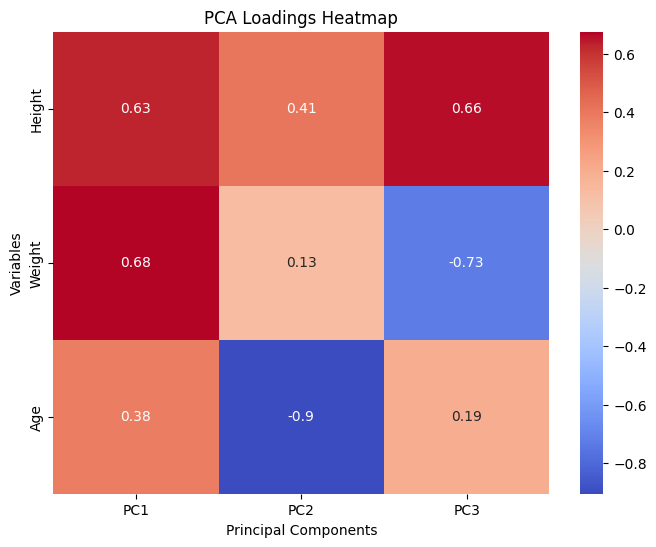

In [41]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Small dataset with 10 datapoints
data = pd.DataFrame({
    'Height': [170, 160, 180, 175, 162, 168, 174, 165, 172, 177],
    'Weight': [65, 70, 80, 75, 68, 72, 77, 66, 74, 78],
    'Age': [25, 32, 28, 35, 29, 22, 30, 27, 33, 31]
})

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Convert back to DataFrame for easy viewing
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# Perform PCA
pca = PCA(n_components=3)  # We have 3 variables, so 3 components
pca.fit(data_scaled)

# Get principal components
principal_components = pca.transform(data_scaled)
principal_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(3)])

# Explained variance
explained_variance_ratio = pca.explained_variance_ratio_

# Show the explained variance
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(3)],
    'Explained Variance Ratio': explained_variance_ratio
})

print("Explained Variance Ratio for Each Principal Component:")
print(explained_variance_df)

# Get the PCA loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(3)], index=data.columns)

# Display the loadings
print("PCA Loadings (Contribution of Variables to Each Component):")
print(loadings)

# Visualize the loadings
plt.figure(figsize=(8, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', cbar=True)
plt.title('PCA Loadings Heatmap')
plt.xlabel('Principal Components')
plt.ylabel('Variables')
plt.show()